# DSC510_Team_Project: Prediction with CatBoost and LightGBM

In this notebook, CatBoost and LightGBM algorithms are utilized for the prediction of the target variable Price for the different books.

After relative research, two algorithms-models, which are variants of the original GB algorithm, were found to be ideal for the task. Specifically, CatBoost and LightGBM were utilized as successors of the baseline models of Section.

The reason behind the distinct use of the two algorithms is their special treatment of the categorical variables. Unlike the rest of the regression algorithms, which only accept data with numerical values during the training process, the nature of the two algorithms, allows them to handle categorical features efficiently and fast. Therefore, the two algorithms, do not require any special pre-processing like one-hot encoding prior to the fit. Specifically, both of the algorithms do not convert to one-hot coding, and thus are much faster than one-hot encoding. 

The two regression models use special algorithms to find the split value of the categorical features instead of transforming them to one-hot. The basic idea of LightGBM is to sort the categories according to the training objective at each split. More specifically, LightGBM sorts the histogram (for a categorical feature) according to its accumulated values and then finds the best split on the sorted histogram (https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features). CatBoost converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features. 

In [1]:
import numpy as np
import pandas as pd

random_state = 420
np.random.seed(random_state) 

## Load preprocessed data

In [2]:
data_df = pd.read_csv('finalized_data_df.csv')
display(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7797 entries, 0 to 7796
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Reviews       7797 non-null   float64
 1   Ratings       7797 non-null   int64  
 2   Genre         7797 non-null   object 
 3   BookCategory  7797 non-null   object 
 4   Price         6237 non-null   float64
 5   Set           7797 non-null   object 
 6   Authors       7797 non-null   object 
 7   No. Authors   7797 non-null   int64  
 8   Print         7797 non-null   object 
 9   Type          7797 non-null   object 
 10  Year          7797 non-null   float64
 11  Topic 0       7797 non-null   float64
 12  Topic 1       7797 non-null   float64
 13  Topic 2       7797 non-null   float64
 14  Topic 3       7797 non-null   float64
 15  Topic 4       7797 non-null   float64
 16  Topic 5       7797 non-null   float64
 17  Topic 6       7797 non-null   float64
 18  Topic 7       7797 non-null 

None

## Data partition and evaluation function-metric

Split to the original train and test and drop the 'set' attribute

In [3]:
# X_train = data_df[data_df['Set'] == 'train']
# y_train = X_train['Price']
# X_train =  X_train.drop(['Set', 'Price', 'No. Authors', 'Cos_Month', 'Sin_Month'], axis=1)

# X_test = data_df[data_df['Set'] == 'test']
# #y_test = X_test['Price']
# X_test =  X_test.drop(['Set', 'Price', 'No. Authors', 'Cos_Month', 'Sin_Month'], axis=1)

X_train = data_df[data_df['Set'] == 'train']
y_train = X_train['Price']
X_train =  X_train.drop(['Set', 'Price'], axis=1)

X_test = data_df[data_df['Set'] == 'test']
#y_test = X_test['Price']
X_test =  X_test.drop(['Set', 'Price'], axis=1)

##### Evaluation metric

Implement evaluation function same as the one from Machine Hack for this task.

Specifically, the evaluation metric used is the Negative Root Mean Squared Logarithmic Error (NRMSLE):

$$ \text { NRMSLE }= 1 - \sqrt{\frac{1}{N} \sum_{i=1}^{N}\left(\log \left(y_{i}+1\right)-\log \left(\hat{y}_{i}+1\right)\right)^{2}} $$

Where:

- $N$  is the total number of observations in the dataset

- $\hat{y_i}$ is the prediction of $i_{th}$ target

- $y_i$ is the actual target for i

- log(.) gives the natural logarithm of the input

NRMSLE adds one to both actual and predicted values before taking the natural logarithm, to avoid taking the natural log of possible zero values. As a result, the metric can be used if actual or predicted have zero-valued elements. https://hrngok.github.io/posts/metrics/

The metric is not appropriate if either is negative valued, but in our case since the target variable is the price, it cannot be negative.

Futhermore, the metric-function is ideal when we don’t want to penalize big differences when both the predicted and the actual are big numbers, and in cases where we want to penalize under-estimates more than over-estimates.
(Kirubakumaresh (KK) Rajendran, Data Science Consultant)

It was found that often in businesses, penalizing the under-estimate more than over-estimate is important for prediction of sales and inventory demands. To some extent having extra inventory or supply might be more preferable to not being able to providing product as much as the demand.

In [4]:
def nrmsle(y_true, y_pred):
    return 1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean())

Implementing custom-user defined loss function for the CatBoost algorithm-package

In [5]:
import numpy as np

# Class which will be used for the CatBoostRegressor evaluation
class NegativeRMSLEMetric(object):
    def get_final_error(self, error, weight):
        return 1 - np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return True # CRUCIAL HERE

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            #1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean())
            error_sum += w * ((np.log10(approx[i]+1)  - np.log10(target[i]+1))**2)

        return error_sum, weight_sum

## Modelling with all features

Initially, all the features were fit in the models in order to see how the algorithms perform

###  Modelling with all features: Catboost

In [17]:
#!pip install catboost

In [14]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

pool_train = Pool(X_train, y_train,
                  cat_features = ['Genre', 'BookCategory', 'Authors', 'Print', 'Type'])

pool_test = Pool(X_test, cat_features = ['Genre', 'BookCategory', 'Authors', 'Print', 'Type'])


cb = CatBoostRegressor(loss_function='RMSE',
                       eval_metric=NegativeRMSLEMetric(),
                       task_type='CPU',
                       random_state=random_state,
                       verbose=False)

grid = {'learning_rate': [0.025, 0.05],
        'max_depth': [5, 10, 15],
        'iterations': [500, 1000]}

grid_search_results = cb.grid_search(grid, X=pool_train, cv=10,
               partition_random_seed=random_state, verbose=True, plot=True)

y_pred = cb.predict(pool_train)
cb_nrmsle = nrmsle(y_train, y_pred)
print("Negative RMSLE in train:", cb_nrmsle)

# Calculate the predictions of the submissions
y_pred = cb.predict(pool_test)

/home/nick/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/catboost/core.py:1953: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7297529522
bestIteration = 498

0:	loss: 0.7297530	best: 0.7297530 (0)	total: 36s	remaining: 6m 35s

bestTest = 0.733805641
bestIteration = 498

1:	loss: 0.7338056	best: 0.7338056 (1)	total: 1m 10s	remaining: 5m 50s

bestTest = 0.7335189622
bestIteration = 998

2:	loss: 0.7335190	best: 0.7338056 (1)	total: 2m 23s	remaining: 7m 9s


/tmp/ipykernel_6634/1355284671.py:27: RuntimeWarning: invalid value encountered in log10
  error_sum += w * ((np.log10(approx[i]+1)  - np.log10(target[i]+1))**2)



bestTest = 0.7350061582
bestIteration = 662

3:	loss: 0.7350062	best: 0.7350062 (3)	total: 3m 32s	remaining: 7m 5s

bestTest = 0.7409201074
bestIteration = 499

4:	loss: 0.7409201	best: 0.7409201 (4)	total: 5m 1s	remaining: 7m 1s

bestTest = 0.7428921028
bestIteration = 330

5:	loss: 0.7428921	best: 0.7428921 (5)	total: 6m 36s	remaining: 6m 36s

bestTest = 0.7442468854
bestIteration = 997

6:	loss: 0.7442469	best: 0.7442469 (6)	total: 9m 15s	remaining: 6m 36s

bestTest = 0.7428921028
bestIteration = 330

7:	loss: 0.7428921	best: 0.7442469 (6)	total: 11m 52s	remaining: 5m 56s

bestTest = 0.7411198431
bestIteration = 499

8:	loss: 0.7411198	best: 0.7442469 (6)	total: 37m 9s	remaining: 12m 23s

bestTest = 0.743086935
bestIteration = 499

9:	loss: 0.7430869	best: 0.7442469 (6)	total: 59m 40s	remaining: 11m 56s

bestTest = 0.7441660202
bestIteration = 997

10:	loss: 0.7441660	best: 0.7442469 (6)	total: 1h 36m 30s	remaining: 8m 46s

bestTest = 0.7435953173
bestIteration = 851

11:	loss: 0.7

{'params': {'depth': 10, 'iterations': 1000, 'learning_rate': 0.025},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,


Negative RMSLE in train: 0.8193828353501815


/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
  return 1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean())


In [33]:
print("Specified best parameters: \n")
for param, val in cb.get_params().items():
    print(param, ":  ", val)
    
#print(cb.get_best_iteration())  
# print("\nAll parameters: \n")
# for param, val in cb.get_all_params().items():
#     print(param, ":  ", val)

Specified parameters: 

loss_function :   RMSE
verbose :   False
eval_metric :   <__main__.NegativeRMSLEMetric object at 0x7f359df4d040>
task_type :   CPU
random_state :   420
depth :   10
iterations :   1000
learning_rate :   0.025

All parameters: 

nan_mode :   Min
eval_metric :   PythonUserDefinedPerObject
combinations_ctr :   ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1']
iterations :   1000
sampling_frequency :   PerTree
fold_permutation_block :   0
leaf_estimation_method :   Newton
counter_calc_method :   SkipTest
grow_policy :   SymmetricTree
penalties_coefficient :   1
boosting_type :   Plain
model_shrink_mode :   Constant
feature_border_type :   GreedyLogSum
ctr_leaf_count_limit :   18446744073709551615
bayesian_matrix_reg :   0.10000000149011612
one_hot_max_size :   2
force_unit_auto_pair_weights :   False
l2_leaf_reg :   3
random_

Run model with the best scores with 10-fold CV

In [43]:
from catboost import CatBoostRegressor, Pool, cv

# 10-fold CV
scores = cv(pool_train,
            cb.get_params(),
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/nick/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/catboost/core.py:6201: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  return _cv(params, pool, fold_count, inverted, partition_random_seed, shuffle, stratified,


Training on fold [0/10]

bestTest = 0.7305993576
bestIteration = 998

Training on fold [1/10]

bestTest = 0.7422871261
bestIteration = 997

Training on fold [2/10]

bestTest = 0.7310382333
bestIteration = 995

Training on fold [3/10]

bestTest = 0.7491836925
bestIteration = 999

Training on fold [4/10]


/tmp/ipykernel_6634/1355284671.py:27: RuntimeWarning: invalid value encountered in log10
  error_sum += w * ((np.log10(approx[i]+1)  - np.log10(target[i]+1))**2)



bestTest = 0.7328288986
bestIteration = 995

Training on fold [5/10]

bestTest = 0.730501842
bestIteration = 909

Training on fold [6/10]

bestTest = 0.7484076332
bestIteration = 802

Training on fold [7/10]

bestTest = 0.7353307372
bestIteration = 673

Training on fold [8/10]

bestTest = 0.7456644867
bestIteration = 842

Training on fold [9/10]

bestTest = 0.7515430163
bestIteration = 998



Showing the mean score of the left out folds

In [65]:
scores.sort_values(by=['test-NegativeRMSLEMetric-mean'], ascending=False)[0:1]

,iterations,test-NegativeRMSLEMetric-mean,test-NegativeRMSLEMetric-std,train-NegativeRMSLEMetric-mean,train-NegativeRMSLEMetric-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
999,999,0.739431,0.008511,NaN,NaN,571.528826,115.376442,299.159908,9.827738


Mean score by iteration of the boosting algorithm

In [59]:
scores.sort_values(by=['test-NegativeRMSLEMetric-mean'], ascending=False)[0:20]

,iterations,test-NegativeRMSLEMetric-mean,test-NegativeRMSLEMetric-std,train-NegativeRMSLEMetric-mean,train-NegativeRMSLEMetric-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
999,999,0.739431,0.008511,NaN,NaN,571.528826,115.376442,299.159908,9.827738
998,998,0.739419,0.008485,NaN,NaN,571.542563,115.386807,299.296800,9.822228
997,997,0.739412,0.008467,NaN,NaN,571.555286,115.387938,299.445896,9.822090
996,996,0.739408,0.008449,NaN,NaN,571.592188,115.390606,299.617052,9.813014
995,995,0.739408,0.008435,NaN,NaN,571.604382,115.402112,299.836769,9.805539
994,994,0.739407,0.008436,NaN,NaN,571.605238,115.403926,299.982154,9.808731
993,993,0.739391,0.008427,NaN,NaN,571.629053,115.390657,300.102759,9.777186
992,992,0.739367,0.008398,NaN,NaN,571.673455,115.398457,300.270355,9.757627
988,988,0.739351,0.008414,NaN,NaN,571.669884,115.367997,300.862691,9.837485
987,987,0.739350,0.008406,NaN,NaN,571.686657,115.329523,301.008496,9.882409


<AxesSubplot:xlabel='iterations', ylabel='test-NegativeRMSLEMetric-mean'>

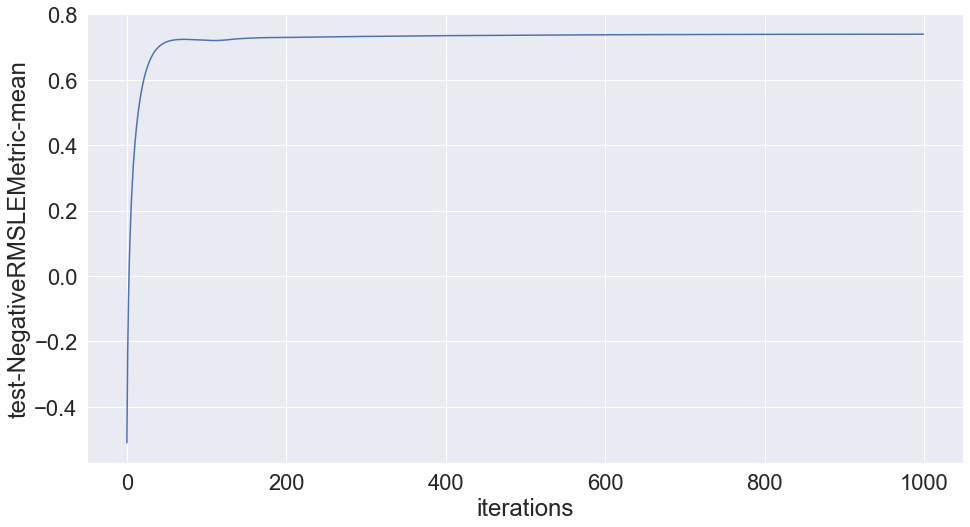

In [60]:
sns.lineplot(data=scores, x="iterations", y="test-NegativeRMSLEMetric-mean")

Retrain the model in all training data, using the optimal hyperparameters found,  and predict on test

In [53]:
# Initialize CatBoostRegressor
model = CatBoostRegressor()

# Fit model with the optimal hyper-parameters
model.set_params(**cb.get_params())
model.fit(pool_train)

# Get predictions, calculate the predictions of the submissions
y_pred = model.predict(pool_test)

/home/nick/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/catboost/core.py:1953: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


Printing/showing feature importances

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(rc={'figure.figsize':(15.7,8.27)})
# sns.set(font_scale = 2)

# for i, importance in enumerate(model.get_feature_importance()):
#     print(importance, ": ", X_train.columns[i])

# ax = sns.barplot(x=X_train.columns, y=model.get_feature_importance())
# for p in ax.patches:
#     ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01), rotation=90, fontsize = 15)
# plt.xticks(rotation=90)
# plt.show()

Saving-exporting the predictions of the test-set to a .csv file

In [54]:
# Saving-exporting the results to a .csv file
pd.DataFrame(y_pred, columns = ['Price']).to_csv('submission_catboost_all_features.csv', index=False)
# 0.74245

###  Modelling with all features: LightGBM

In [66]:
for col_name in X_train.select_dtypes(include=['object']):
    X_test[col_name] = X_test[col_name].astype('category')
    X_train[col_name] = X_train[col_name].astype('category')

In [67]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgbm = lightgbm.LGBMRegressor(random_state = 420, n_jobs = -1)

# Using many estimators with low learning rates
lgbm_params = {'learning_rate': [0.02, 0.035, 0.05],
                           'num_leaves':[62, 124, 136],
                           'max_depth': [5, 10, 15],
                           'n_estimators': [1000, 2000, 3000],
                           'objective': ['regression_l1']}

lgbm_grid_search = GridSearchCV(estimator = lgbm, 
                                param_grid =  lgbm_params,
                                cv=10,
                                verbose = 10,
                                scoring = make_scorer(nrmsle, greater_is_better=True),
                                n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV 1/10; 1/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 1/10; 1/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.748 total time=   5.6s
[CV 3/10; 2/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 3/10; 2/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1;, score=0.750 total time=   7.6s
[CV 10/10; 2/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 10/10; 2/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1;, score=0.723 total time=   9.8s
[CV 6/10; 3/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 6/10; 3/81] END learning_rate=0.02, max_de

[CV 3/10; 1/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 3/10; 1/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.750 total time=   5.3s
[CV 10/10; 1/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 10/10; 1/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.723 total time=   6.6s
[CV 7/10; 2/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 7/10; 2/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1;, score=0.742 total time=  11.5s
[CV 7/10; 3/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 7/10; 3/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1

[CV 6/10; 1/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 6/10; 1/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.759 total time=   5.7s
[CV 6/10; 2/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 6/10; 2/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1;, score=0.759 total time=   8.2s
[CV 3/10; 3/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 3/10; 3/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1;, score=0.750 total time=  10.4s
[CV 10/10; 3/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 10/10; 3/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_

[CV 4/10; 1/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 4/10; 1/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.739 total time=   5.7s
[CV 5/10; 2/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 5/10; 2/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=124, objective=regression_l1;, score=0.735 total time=   7.9s
[CV 2/10; 3/81] START learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 2/10; 3/81] END learning_rate=0.02, max_depth=5, n_estimators=1000, num_leaves=136, objective=regression_l1;, score=0.758 total time=  11.0s
[CV 1/10; 4/81] START learning_rate=0.02, max_depth=5, n_estimators=2000, num_leaves=62, objective=regression_l1
[CV 1/10; 4/81] END learning_rate=0.02, max_depth=5, n_estimators=2000, num_leaves=62, objective=regression_l1;,

[CV 9/10; 24/81] START learning_rate=0.02, max_depth=15, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 9/10; 24/81] END learning_rate=0.02, max_depth=15, n_estimators=2000, num_leaves=136, objective=regression_l1;, score=0.742 total time= 2.5min
[CV 8/10; 25/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 8/10; 25/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.738 total time= 1.6min
[CV 6/10; 26/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 6/10; 26/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.772 total time= 2.8min
[CV 3/10; 27/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 3/10; 27/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objecti

[CV 1/10; 25/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 1/10; 25/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.757 total time= 2.0min
[CV 7/10; 25/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 7/10; 25/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.750 total time= 1.6min
[CV 5/10; 26/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 5/10; 26/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.741 total time= 3.0min
[CV 5/10; 27/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 5/10; 27/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective

[CV 1/10; 26/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 1/10; 26/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.757 total time= 2.7min
[CV 9/10; 26/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 9/10; 26/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.744 total time= 3.2min
[CV 8/10; 27/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 8/10; 27/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.739 total time= 3.2min
[CV 5/10; 31/81] START learning_rate=0.035, max_depth=5, n_estimators=2000, num_leaves=62, objective=regression_l1
[CV 5/10; 31/81] END learning_rate=0.035, max_depth=5, n_estimators=2000, num_leaves=62, objecti

[CV 1/10; 27/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 1/10; 27/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.756 total time= 3.4min
[CV 9/10; 27/81] START learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 9/10; 27/81] END learning_rate=0.02, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.742 total time= 2.8min
[CV 2/10; 33/81] START learning_rate=0.035, max_depth=5, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 2/10; 33/81] END learning_rate=0.035, max_depth=5, n_estimators=2000, num_leaves=136, objective=regression_l1;, score=0.758 total time=  14.2s
[CV 9/10; 33/81] START learning_rate=0.035, max_depth=5, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 9/10; 33/81] END learning_rate=0.035, max_depth=5, n_estimators=2000, num_leaves=136, objec

[CV 4/10; 47/81] START learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 4/10; 47/81] END learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=124, objective=regression_l1;, score=0.741 total time=  34.5s
[CV 2/10; 48/81] START learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 2/10; 48/81] END learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=136, objective=regression_l1;, score=0.760 total time=  37.9s
[CV 10/10; 48/81] START learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 10/10; 48/81] END learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=136, objective=regression_l1;, score=0.729 total time=  33.6s
[CV 8/10; 49/81] START learning_rate=0.035, max_depth=15, n_estimators=2000, num_leaves=62, objective=regression_l1
[CV 8/10; 49/81] END learning_rate=0.035, max_depth=15, n_estimators=2000, num_leaves=6

[CV 1/10; 46/81] START learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 1/10; 46/81] END learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.756 total time=  21.3s
[CV 5/10; 46/81] START learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 5/10; 46/81] END learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.739 total time=  19.7s
[CV 9/10; 46/81] START learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 9/10; 46/81] END learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.743 total time=  19.1s
[CV 7/10; 47/81] START learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 7/10; 47/81] END learning_rate=0.035, max_depth=15, n_estimators=1000, num_leaves=124, obj

[CV 4/10; 54/81] START learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 4/10; 54/81] END learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.740 total time= 1.7min
[CV 1/10; 55/81] START learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 1/10; 55/81] END learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.750 total time=   5.4s
[CV 3/10; 55/81] START learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 3/10; 55/81] END learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.752 total time=   6.0s
[CV 7/10; 55/81] START learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 7/10; 55/81] END learning_rate=0.05, max_depth=5, n_estimators=1000, num_leaves=62, objective=regre

[CV 3/10; 53/81] START learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 3/10; 53/81] END learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.758 total time= 1.6min
[CV 1/10; 54/81] START learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 1/10; 54/81] END learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.757 total time= 1.7min
[CV 9/10; 54/81] START learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 9/10; 54/81] END learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.744 total time= 1.5min
[CV 8/10; 59/81] START learning_rate=0.05, max_depth=5, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 8/10; 59/81] END learning_rate=0.05, max_depth=5, n_estimators=2000, num_leaves=124, o

[CV 3/10; 78/81] START learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 3/10; 78/81] END learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=136, objective=regression_l1;, score=0.758 total time= 1.1min
[CV 1/10; 79/81] START learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 1/10; 79/81] END learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.754 total time=  56.5s
[CV 7/10; 79/81] START learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 7/10; 79/81] END learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.752 total time=  55.6s
[CV 5/10; 80/81] START learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 5/10; 80/81] END learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=124, objective

/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10


[CV 10/10; 54/81] END learning_rate=0.035, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.731 total time= 1.5min
[CV 10/10; 59/81] START learning_rate=0.05, max_depth=5, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 10/10; 59/81] END learning_rate=0.05, max_depth=5, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.726 total time=  10.3s
[CV 8/10; 60/81] START learning_rate=0.05, max_depth=5, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 8/10; 60/81] END learning_rate=0.05, max_depth=5, n_estimators=2000, num_leaves=136, objective=regression_l1;, score=0.735 total time=  10.4s
[CV 6/10; 61/81] START learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 6/10; 61/81] END learning_rate=0.05, max_depth=5, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.762 total time=  15.4s
[CV 4/10; 62/81] START learning_rate=0.05, max_depth=5, n_estimators

/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10


[CV 4/10; 72/81] START learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 4/10; 72/81] END learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.744 total time=  59.6s
[CV 2/10; 73/81] START learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 2/10; 73/81] END learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.761 total time=  18.6s
[CV 6/10; 73/81] START learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1
[CV 6/10; 73/81] END learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=62, objective=regression_l1;, score=0.764 total time=  18.4s
[CV 2/10; 74/81] START learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=124, objective=regression_l1
[CV 2/10; 74/81] END learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=124, objective

/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10


[CV 10/10; 75/81] START learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=136, objective=regression_l1
[CV 10/10; 75/81] END learning_rate=0.05, max_depth=15, n_estimators=1000, num_leaves=136, objective=regression_l1;, score=0.731 total time=  32.8s
[CV 8/10; 76/81] START learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=62, objective=regression_l1
[CV 8/10; 76/81] END learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=62, objective=regression_l1;, score=0.737 total time=  37.3s
[CV 6/10; 77/81] START learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 6/10; 77/81] END learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.768 total time= 1.0min
[CV 4/10; 78/81] START learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 4/10; 78/81] END learning_rate=0.05, max_depth=15, n_estimators=2000, num_leaves=136, objec

/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10


[CV 9/10; 81/81] START learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 9/10; 81/81] END learning_rate=0.05, max_depth=15, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.744 total time=  55.6s


/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10
/tmp/ipykernel_6634/1355284671.py:4: RuntimeWarning: invalid value encountered in log10


[CV 1/10; 69/81] START learning_rate=0.05, max_depth=10, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 1/10; 69/81] END learning_rate=0.05, max_depth=10, n_estimators=2000, num_leaves=136, objective=regression_l1;, score=0.757 total time=  39.0s
[CV 9/10; 69/81] START learning_rate=0.05, max_depth=10, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 9/10; 69/81] END learning_rate=0.05, max_depth=10, n_estimators=2000, num_leaves=136, objective=regression_l1;, score=0.745 total time=  38.6s
[CV 7/10; 70/81] START learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 7/10; 70/81] END learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.754 total time=  50.2s
[CV 5/10; 71/81] START learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 5/10; 71/81] END learning_rate=0.05, max_depth=10, n_estimators=3000, num_leaves=124, objecti

In [69]:
print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

print("The best score of all model parameters' combination on model: {:.4f}".format(lgbm_grid_search.best_score_))
display(pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by=['rank_test_score'])[['mean_fit_time', 'mean_score_time', 
                                           'params', 'mean_test_score', 'rank_test_score']])


The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.035, max_depth=15, n_estimators=2000,
              num_leaves=124, objective='regression_l1', random_state=420)
The best score of all model parameters' combination on model: 0.7500


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
49,63.333721,1.768293,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.750035,1
25,169.099287,3.776577,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.749898,2
52,94.198981,2.552990,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.749892,3
22,165.170166,3.917972,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.749705,4
51,54.247144,1.888090,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.749651,5
...,...,...,...,...,...
4,23.306918,1.344839,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.742534,76
5,24.040783,1.065241,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.742534,76
1,8.553992,0.314116,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.742342,79
2,11.233435,0.369529,"{'learning_rate': 0.02, 'max_depth': 5, 'n_est...",0.742342,79


In [70]:
model = lgbm_grid_search.best_estimator_

model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

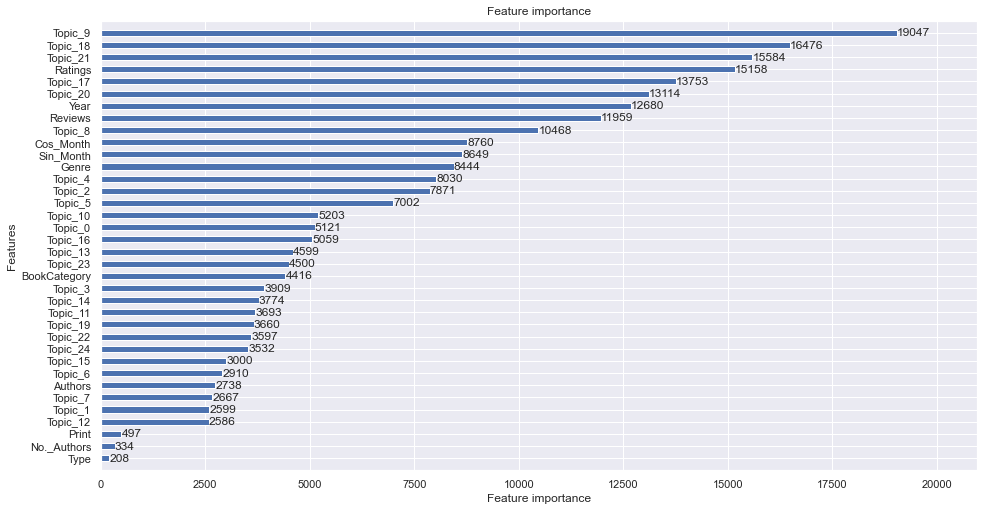

In [80]:
sns.set(font_scale = 1)
lightgbm.plot_importance(model, height=0.5)

In [81]:
# Saving-exporting the results to a .csv file
pd.DataFrame(predictions, columns = ['Price']).to_csv('submission_lgbm_all_features.csv', index=False)
# 0.75938

### Modelling without the No. Authors Features: LightGBM

In [83]:
X_train = data_df[data_df['Set'] == 'train']
y_train = X_train['Price']
X_train =  X_train.drop(['Set', 'Price', 'No. Authors'], axis=1)

X_test = data_df[data_df['Set'] == 'test']
#y_test = X_test['Price']
X_test =  X_test.drop(['Set', 'Price', 'No. Authors'], axis=1)

In [84]:
for col_name in X_train.select_dtypes(include=['object']):
    X_test[col_name] = X_test[col_name].astype('category')
    X_train[col_name] = X_train[col_name].astype('category')

In [85]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgbm = lightgbm.LGBMRegressor(random_state = 420, n_jobs = -1)

# Using many estimators with low learning rates
lgbm_params = {'learning_rate': [0.02, 0.035, 0.05],
                           'num_leaves':[62, 124, 136],
                           'max_depth': [10, 15],
                           'n_estimators': [1500, 2000, 3000],
                           'objective': ['regression_l1']}

lgbm_grid_search = GridSearchCV(estimator = lgbm, 
                                param_grid =  lgbm_params,
                                cv=10,
                                verbose = 10,
                                scoring = make_scorer(nrmsle, greater_is_better=True),
                                n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV 7/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 7/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.751 total time=  43.2s
[CV 6/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 6/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.769 total time=  46.2s
[CV 9/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 9/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.744 total time=  51.0s
[CV 7/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 7/10; 3/54] END learning_rate=0.02, m

[CV 1/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 1/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.755 total time=  42.1s
[CV 2/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 2/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.762 total time=  54.0s
[CV 1/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 1/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1;, score=0.753 total time=  51.6s
[CV 9/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 9/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regre

[CV 8/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 8/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.738 total time=  42.3s
[CV 5/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 5/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.740 total time=  56.6s
[CV 4/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 4/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1;, score=0.745 total time=  50.4s
[CV 1/10; 4/54] START learning_rate=0.02, max_depth=10, n_estimators=2000, num_leaves=62, objective=regression_l1
[CV 1/10; 4/54] END learning_rate=0.02, max_depth=10, n_estimators=2000, num_leaves=62, objective=regress

[CV 4/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 4/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.743 total time=  42.1s
[CV 4/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 4/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.744 total time=  54.3s
[CV 3/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 3/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1;, score=0.758 total time=  53.7s
[CV 2/10; 4/54] START learning_rate=0.02, max_depth=10, n_estimators=2000, num_leaves=62, objective=regression_l1
[CV 2/10; 4/54] END learning_rate=0.02, max_depth=10, n_estimators=2000, num_leaves=62, objective=regress

[CV 9/10; 24/54] START learning_rate=0.035, max_depth=10, n_estimators=2000, num_leaves=136, objective=regression_l1
[CV 9/10; 24/54] END learning_rate=0.035, max_depth=10, n_estimators=2000, num_leaves=136, objective=regression_l1;, score=0.745 total time=  40.7s
[CV 7/10; 25/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 7/10; 25/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.748 total time=  52.2s
[CV 6/10; 26/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 6/10; 26/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.769 total time= 1.0min
[CV 3/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 3/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136,

[CV 1/10; 25/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 1/10; 25/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.753 total time=  51.9s
[CV 9/10; 25/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 9/10; 25/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.744 total time=  50.6s
[CV 7/10; 26/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 7/10; 26/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.750 total time= 1.0min
[CV 5/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 5/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, o

[CV 10/10; 25/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 10/10; 25/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.733 total time=  52.4s
[CV 8/10; 26/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 8/10; 26/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.738 total time= 1.0min
[CV 6/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 6/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.769 total time= 1.0min
[CV 3/10; 28/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 3/10; 28/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62,

[CV 2/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 2/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.762 total time= 1.0min
[CV 10/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 10/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.731 total time= 1.0min
[CV 2/10; 29/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 2/10; 29/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.760 total time=  50.3s
[CV 10/10; 29/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 10/10; 29/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leave

The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.02, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)


In [86]:
print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

print("The best score of all model parameters' combination on model: {:.4f}".format(lgbm_grid_search.best_score_))
display(pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by=['rank_test_score'])[['mean_fit_time', 'mean_score_time', 
                                           'params', 'mean_test_score', 'rank_test_score']])


The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.02, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)
The best score of all model parameters' combination on model: 0.7505


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
16,130.517815,2.595433,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.750464,1
13,104.268577,2.379258,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.750107,2
33,99.642117,2.961967,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.750049,3
30,36.976591,1.206871,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.749940,4
10,77.763356,1.316621,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.749867,5
35,162.411212,3.128679,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.749798,6
27,27.516474,0.968823,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.749703,7
8,110.726966,3.181831,"{'learning_rate': 0.02, 'max_depth': 10, 'n_es...",0.749568,8
34,156.414271,3.345154,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.749330,9
5,52.866065,1.243552,"{'learning_rate': 0.02, 'max_depth': 10, 'n_es...",0.749288,10


In [87]:
model = lgbm_grid_search.best_estimator_

model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

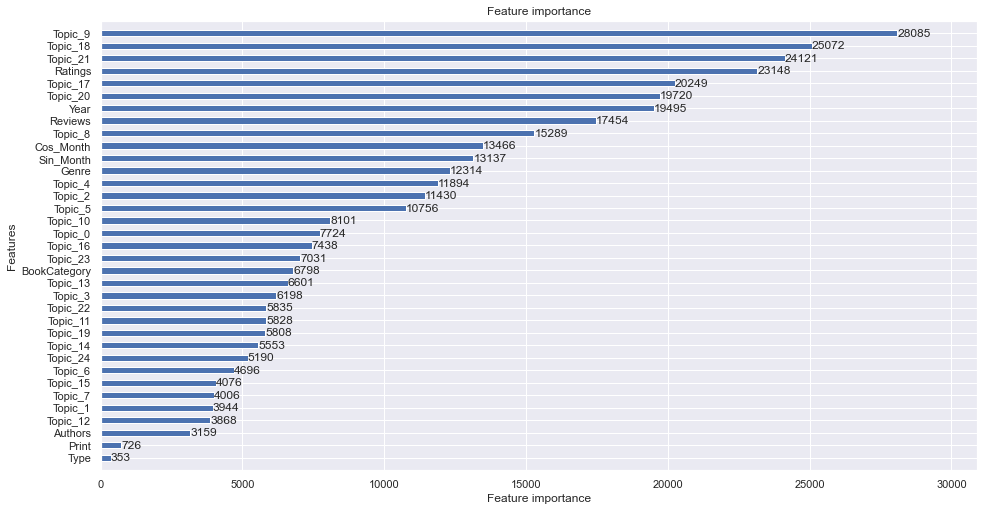

In [88]:
sns.set(font_scale = 1)
lightgbm.plot_importance(model, height=0.5)

In [90]:
# Saving-exporting the results to a .csv file
pd.DataFrame(predictions, columns = ['Price']).to_csv('submission_lgbm_no_authors_removed.csv', index=False)
# 0.75788

### Modelling without the Type: LightGBM

In [93]:
X_train = data_df[data_df['Set'] == 'train']
y_train = X_train['Price']
X_train =  X_train.drop(['Set', 'Price', 'Type'], axis=1)

X_test = data_df[data_df['Set'] == 'test']
#y_test = X_test['Price']
X_test =  X_test.drop(['Set', 'Price', 'Type'], axis=1)

In [94]:
for col_name in X_train.select_dtypes(include=['object']):
    X_test[col_name] = X_test[col_name].astype('category')
    X_train[col_name] = X_train[col_name].astype('category')

In [95]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgbm = lightgbm.LGBMRegressor(random_state = 420, n_jobs = -1)

# Using many estimators with low learning rates
lgbm_params = {'learning_rate': [0.02, 0.035, 0.05],
                           'num_leaves':[62, 124, 136],
                           'max_depth': [10, 15],
                           'n_estimators': [1500, 2000, 3000],
                           'objective': ['regression_l1']}

lgbm_grid_search = GridSearchCV(estimator = lgbm, 
                                param_grid =  lgbm_params,
                                cv=10,
                                verbose = 10,
                                scoring = make_scorer(nrmsle, greater_is_better=True),
                                n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV 5/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 5/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.737 total time=  30.9s
[CV 6/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 6/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.767 total time=  34.3s
[CV 10/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 10/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.729 total time=  37.1s
[CV 8/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 8/10; 3/54] END learning_rate=0.02,

[CV 4/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 4/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.741 total time=  29.8s
[CV 10/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 10/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.728 total time=  29.7s
[CV 8/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 8/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.736 total time=  34.9s
[CV 6/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 6/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regre

[CV 2/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 2/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.761 total time=  30.1s
[CV 3/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 3/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.755 total time=  37.2s
[CV 4/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 4/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1;, score=0.743 total time=  36.1s
[CV 1/10; 4/54] START learning_rate=0.02, max_depth=10, n_estimators=2000, num_leaves=62, objective=regression_l1
[CV 1/10; 4/54] END learning_rate=0.02, max_depth=10, n_estimators=2000, num_leaves=62, objective=regress

[CV 3/10; 1/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 3/10; 1/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.754 total time=  30.3s
[CV 4/10; 2/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 4/10; 2/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=124, objective=regression_l1;, score=0.743 total time=  36.5s
[CV 2/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 2/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1;, score=0.761 total time=  36.3s
[CV 9/10; 3/54] START learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regression_l1
[CV 9/10; 3/54] END learning_rate=0.02, max_depth=10, n_estimators=1500, num_leaves=136, objective=regre

[CV 8/10; 25/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1
[CV 8/10; 25/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=62, objective=regression_l1;, score=0.738 total time=  59.5s
[CV 6/10; 26/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 6/10; 26/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.765 total time= 1.2min
[CV 4/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 4/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.743 total time= 1.2min
[CV 2/10; 28/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 2/10; 28/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62, o

[CV 9/10; 26/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 9/10; 26/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.742 total time= 1.2min
[CV 7/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 7/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.750 total time= 1.2min
[CV 7/10; 28/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 7/10; 28/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.749 total time=  34.4s
[CV 5/10; 29/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 5/10; 29/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=124,

[CV 3/10; 26/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 3/10; 26/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.757 total time= 1.2min
[CV 1/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 1/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.756 total time= 1.2min
[CV 9/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 9/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.740 total time= 1.2min
[CV 1/10; 29/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 1/10; 29/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=12

[CV 10/10; 26/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 10/10; 26/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.733 total time= 1.2min
[CV 8/10; 27/54] START learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1
[CV 8/10; 27/54] END learning_rate=0.035, max_depth=10, n_estimators=3000, num_leaves=136, objective=regression_l1;, score=0.738 total time= 1.2min
[CV 8/10; 28/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62, objective=regression_l1
[CV 8/10; 28/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=62, objective=regression_l1;, score=0.739 total time=  33.0s
[CV 6/10; 29/54] START learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=124, objective=regression_l1
[CV 6/10; 29/54] END learning_rate=0.035, max_depth=15, n_estimators=1500, num_leaves=12

The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.02, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)


In [96]:
print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

print("The best score of all model parameters' combination on model: {:.4f}".format(lgbm_grid_search.best_score_))
display(pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by=['rank_test_score'])[['mean_fit_time', 'mean_score_time', 
                                           'params', 'mean_test_score', 'rank_test_score']])


The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.02, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)
The best score of all model parameters' combination on model: 0.7488


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
16,108.504072,2.775470,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.748817,1
15,65.138029,1.879507,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.748763,2
17,122.188814,2.510783,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.748735,3
35,109.664678,2.630751,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.748682,4
13,71.569562,1.622713,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.748602,5
34,105.529463,2.605351,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.748537,6
12,43.761588,1.243919,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.748513,7
14,75.818199,1.692896,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.748462,8
11,68.650922,1.712815,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.748441,9
31,71.140385,1.512507,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.748432,10


In [97]:
model = lgbm_grid_search.best_estimator_

model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

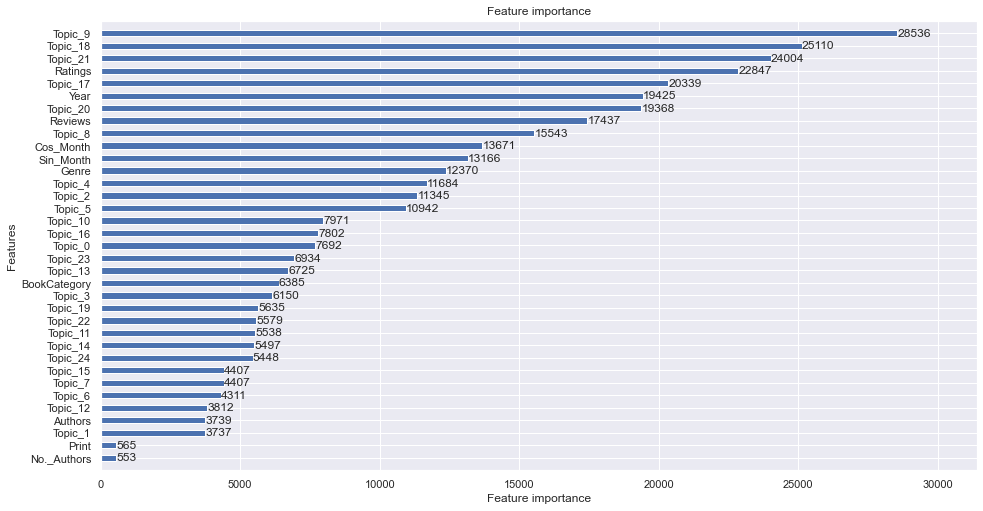

In [98]:
sns.set(font_scale = 1)
lightgbm.plot_importance(model, height=0.5)

In [100]:
# Saving-exporting the results to a .csv file
pd.DataFrame(predictions, columns = ['Price']).to_csv('submission_lgbm_type_removed.csv', index=False)
# 0.75772

### Modelling without the Print: LightGBM

In [101]:
X_train = data_df[data_df['Set'] == 'train']
y_train = X_train['Price']
X_train =  X_train.drop(['Set', 'Price', 'Print'], axis=1)

X_test = data_df[data_df['Set'] == 'test']
#y_test = X_test['Price']
X_test =  X_test.drop(['Set', 'Price', 'Print'], axis=1)

In [102]:
for col_name in X_train.select_dtypes(include=['object']):
    X_test[col_name] = X_test[col_name].astype('category')
    X_train[col_name] = X_train[col_name].astype('category')

In [103]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgbm = lightgbm.LGBMRegressor(random_state = 420, n_jobs = -1)

# Using many estimators with low learning rates
lgbm_params = {'learning_rate': [0.02, 0.035],
                           'num_leaves':[124],
                           'max_depth': [15],
                           'n_estimators': [2000, 3000],
                           'objective': ['regression_l1']}

lgbm_grid_search = GridSearchCV(estimator = lgbm, 
                                param_grid =  lgbm_params,
                                cv=10,
                                verbose = 10,
                                scoring = make_scorer(nrmsle, greater_is_better=True),
                                n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.035, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)


In [104]:
print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

print("The best score of all model parameters' combination on model: {:.4f}".format(lgbm_grid_search.best_score_))
display(pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by=['rank_test_score'])[['mean_fit_time', 'mean_score_time', 
                                           'params', 'mean_test_score', 'rank_test_score']])


The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.035, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)
The best score of all model parameters' combination on model: 0.7414


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
3,116.848466,2.604575,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.741371,1
2,73.869622,1.665040,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.741136,2
1,116.083604,3.092865,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.740885,3
0,80.648749,1.463908,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.740498,4


In [105]:
model = lgbm_grid_search.best_estimator_

model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

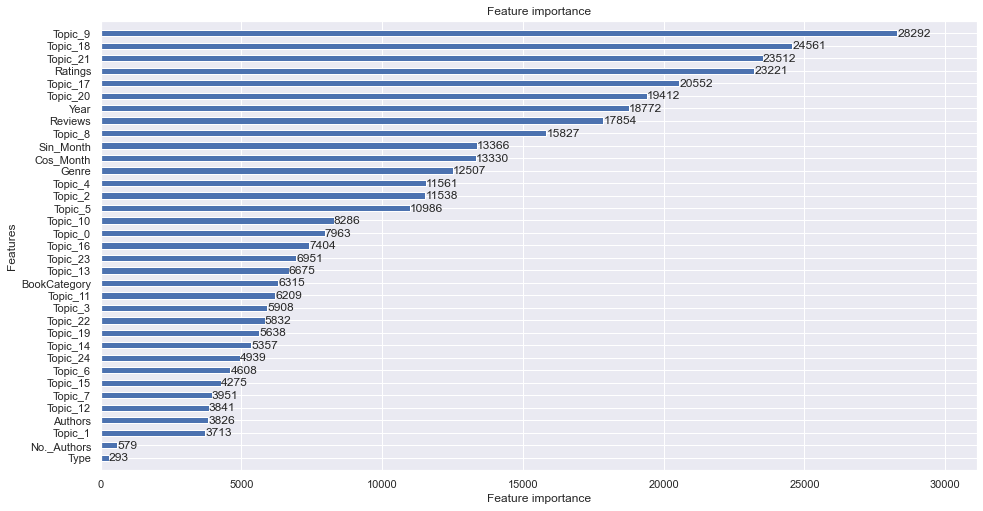

In [106]:
sns.set(font_scale = 1)
lightgbm.plot_importance(model, height=0.5)

In [108]:
# Saving-exporting the results to a .csv file
pd.DataFrame(predictions, columns = ['Price']).to_csv('submission_lgbm_print_removed.csv', index=False)
# 0.75335

### Modelling without all of the three "non-important" features: LightGBM

In [109]:
X_train = data_df[data_df['Set'] == 'train']
y_train = X_train['Price']
X_train =  X_train.drop(['Set', 'Price', 'Print', 'Type', 'No. Authors'], axis=1)

X_test = data_df[data_df['Set'] == 'test']
#y_test = X_test['Price']
X_test =  X_test.drop(['Set', 'Price', 'Print', 'Type', 'No. Authors'], axis=1)

In [110]:
for col_name in X_train.select_dtypes(include=['object']):
    X_test[col_name] = X_test[col_name].astype('category')
    X_train[col_name] = X_train[col_name].astype('category')

In [111]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgbm = lightgbm.LGBMRegressor(random_state = 420, n_jobs = -1)

# Using many estimators with low learning rates
lgbm_params = {'learning_rate': [0.02, 0.035],
                           'num_leaves':[124],
                           'max_depth': [10, 15],
                           'n_estimators': [2000, 3000],
                           'objective': ['regression_l1']}

lgbm_grid_search = GridSearchCV(estimator = lgbm, 
                                param_grid =  lgbm_params,
                                cv=10,
                                verbose = 10,
                                scoring = make_scorer(nrmsle, greater_is_better=True),
                                n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.035, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)


In [112]:
print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

print("The best score of all model parameters' combination on model: {:.4f}".format(lgbm_grid_search.best_score_))
display(pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by=['rank_test_score'])[['mean_fit_time', 'mean_score_time', 
                                           'params', 'mean_test_score', 'rank_test_score']])


The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.035, max_depth=15, n_estimators=3000,
              num_leaves=124, objective='regression_l1', random_state=420)
The best score of all model parameters' combination on model: 0.7398


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
7,91.900071,1.789789,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.739831,1
6,65.223878,1.722024,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.739798,2
3,117.017870,2.084824,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.739678,3
2,71.708829,1.475056,"{'learning_rate': 0.02, 'max_depth': 15, 'n_es...",0.739560,4
5,69.157411,2.110314,"{'learning_rate': 0.035, 'max_depth': 10, 'n_e...",0.739080,5
1,67.495301,2.196973,"{'learning_rate': 0.02, 'max_depth': 10, 'n_es...",0.739064,6
4,50.018190,1.384308,"{'learning_rate': 0.035, 'max_depth': 10, 'n_e...",0.738840,7
0,44.078613,1.355546,"{'learning_rate': 0.02, 'max_depth': 10, 'n_es...",0.738811,8


In [113]:
model = lgbm_grid_search.best_estimator_

model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

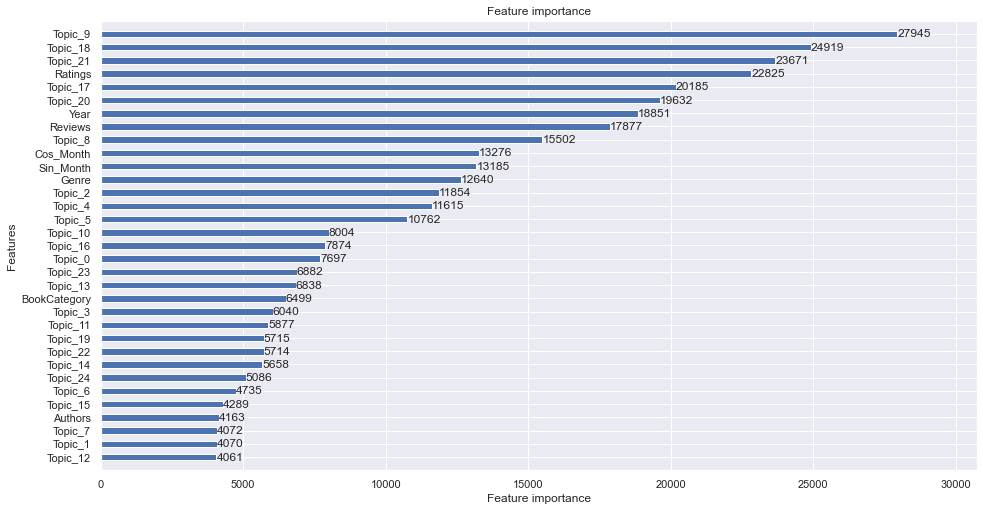

In [114]:
sns.set(font_scale = 1)
lightgbm.plot_importance(model, height=0.5)

In [116]:
# Saving-exporting the results to a .csv file
pd.DataFrame(predictions, columns = ['Price']).to_csv('submission_lgbm_non_important_removed.csv', index=False)
# 0.75277

### FInal Modelling for the best LightGBM model

In [6]:
X_train = data_df[data_df['Set'] == 'train']
y_train = X_train['Price']
X_train =  X_train.drop(['Set', 'Price'], axis=1)

X_test = data_df[data_df['Set'] == 'test']
#y_test = X_test['Price']
X_test =  X_test.drop(['Set', 'Price'], axis=1)

In [7]:
for col_name in X_train.select_dtypes(include=['object']):
    X_test[col_name] = X_test[col_name].astype('category')
    X_train[col_name] = X_train[col_name].astype('category')

In [119]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgbm = lightgbm.LGBMRegressor(random_state = 420, n_jobs = -1)

# Using many estimators with low learning rates
lgbm_params = {'learning_rate': [0.01, 0.02, 0.03, 0.035, 0.04],
                           'num_leaves':[124],
                           'max_depth': [12, 15, 18],
                           'n_estimators': [2000, 2500, 3000, 3500],
                           'objective': ['regression_l1']}

lgbm_grid_search = GridSearchCV(estimator = lgbm, 
                                param_grid =  lgbm_params,
                                cv=10,
                                verbose = 10,
                                scoring = make_scorer(nrmsle, greater_is_better=True),
                                n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 3/10; 1/60] START learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 3/10; 1/60] END learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.757 total time= 1.1min
[CV 9/10; 1/60] START learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 9/10; 1/60] END learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.744 total time= 1.2min
[CV 8/10; 2/60] START learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 8/10; 2/60] END learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.742 total time= 1.4min
[CV 5/10; 3/60] START learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 5/10; 3/60] END learning_rate=0.01,

[CV 4/10; 1/60] START learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 4/10; 1/60] END learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.743 total time= 1.1min
[CV 1/10; 2/60] START learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 1/10; 2/60] END learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.757 total time= 1.4min
[CV 10/10; 2/60] START learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 10/10; 2/60] END learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.730 total time= 1.4min
[CV 8/10; 3/60] START learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 8/10; 3/60] END learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=r

[CV 1/10; 1/60] START learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 1/10; 1/60] END learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.757 total time= 1.2min
[CV 4/10; 2/60] START learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 4/10; 2/60] END learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.743 total time= 1.4min
[CV 2/10; 3/60] START learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 2/10; 3/60] END learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.761 total time= 1.7min
[CV 9/10; 3/60] START learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 9/10; 3/60] END learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=reg

[CV 6/10; 1/60] START learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 6/10; 1/60] END learning_rate=0.01, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.768 total time= 1.2min
[CV 6/10; 2/60] START learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 6/10; 2/60] END learning_rate=0.01, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.769 total time= 1.5min
[CV 4/10; 3/60] START learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 4/10; 3/60] END learning_rate=0.01, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.744 total time= 1.7min
[CV 2/10; 4/60] START learning_rate=0.01, max_depth=12, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 2/10; 4/60] END learning_rate=0.01, max_depth=12, n_estimators=3500, num_leaves=124, objective=reg

[CV 10/10; 25/60] START learning_rate=0.03, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 10/10; 25/60] END learning_rate=0.03, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.732 total time=  56.3s
[CV 8/10; 26/60] START learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 8/10; 26/60] END learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.740 total time= 1.1min
[CV 6/10; 27/60] START learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 6/10; 27/60] END learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.772 total time= 1.4min
[CV 4/10; 28/60] START learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 4/10; 28/60] END learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, obj

[CV 5/10; 25/60] START learning_rate=0.03, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 5/10; 25/60] END learning_rate=0.03, max_depth=12, n_estimators=2000, num_leaves=124, objective=regression_l1;, score=0.740 total time=  57.2s
[CV 4/10; 26/60] START learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 4/10; 26/60] END learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.741 total time= 1.2min
[CV 2/10; 27/60] START learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 2/10; 27/60] END learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.760 total time= 1.4min
[CV 10/10; 27/60] START learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 10/10; 27/60] END learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, obj

[CV 6/10; 26/60] START learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 6/10; 26/60] END learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.772 total time= 1.2min
[CV 4/10; 27/60] START learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 4/10; 27/60] END learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.741 total time= 1.4min
[CV 2/10; 28/60] START learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 2/10; 28/60] END learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.760 total time= 1.6min
[CV 10/10; 28/60] START learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 10/10; 28/60] END learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, obj

[CV 7/10; 26/60] START learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1
[CV 7/10; 26/60] END learning_rate=0.03, max_depth=12, n_estimators=2500, num_leaves=124, objective=regression_l1;, score=0.753 total time= 1.2min
[CV 5/10; 27/60] START learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1
[CV 5/10; 27/60] END learning_rate=0.03, max_depth=12, n_estimators=3000, num_leaves=124, objective=regression_l1;, score=0.740 total time= 1.4min
[CV 3/10; 28/60] START learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 3/10; 28/60] END learning_rate=0.03, max_depth=12, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.756 total time= 1.6min
[CV 1/10; 29/60] START learning_rate=0.03, max_depth=15, n_estimators=2000, num_leaves=124, objective=regression_l1
[CV 1/10; 29/60] END learning_rate=0.03, max_depth=15, n_estimators=2000, num_leaves=124, objec

The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.04, max_depth=18, n_estimators=3500,
              num_leaves=124, objective='regression_l1', random_state=420)


In [120]:
print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

print("The best score of all model parameters' combination on model: {:.4f}".format(lgbm_grid_search.best_score_))
display(pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by=['rank_test_score'])[['mean_fit_time', 'mean_score_time', 
                                           'params', 'mean_test_score', 'rank_test_score']])


The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.04, max_depth=18, n_estimators=3500,
              num_leaves=124, objective='regression_l1', random_state=420)
The best score of all model parameters' combination on model: 0.7504


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
59,145.201953,2.303159,"{'learning_rate': 0.04, 'max_depth': 18, 'n_es...",0.750436,1
43,110.909664,2.936009,"{'learning_rate': 0.035, 'max_depth': 15, 'n_e...",0.750431,2
58,180.215694,4.261945,"{'learning_rate': 0.04, 'max_depth': 18, 'n_es...",0.750385,3
23,116.052360,2.882599,"{'learning_rate': 0.02, 'max_depth': 18, 'n_es...",0.750298,4
57,122.738013,3.598641,"{'learning_rate': 0.04, 'max_depth': 18, 'n_es...",0.750270,5
22,100.178908,2.451278,"{'learning_rate': 0.02, 'max_depth': 18, 'n_es...",0.750217,6
35,115.866784,2.889992,"{'learning_rate': 0.03, 'max_depth': 18, 'n_es...",0.750179,7
11,114.961685,2.815270,"{'learning_rate': 0.01, 'max_depth': 18, 'n_es...",0.750153,8
56,77.106095,1.979178,"{'learning_rate': 0.04, 'max_depth': 18, 'n_es...",0.750147,9
34,99.901606,2.526900,"{'learning_rate': 0.03, 'max_depth': 18, 'n_es...",0.750116,10


In [121]:
model = lgbm_grid_search.best_estimator_

model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

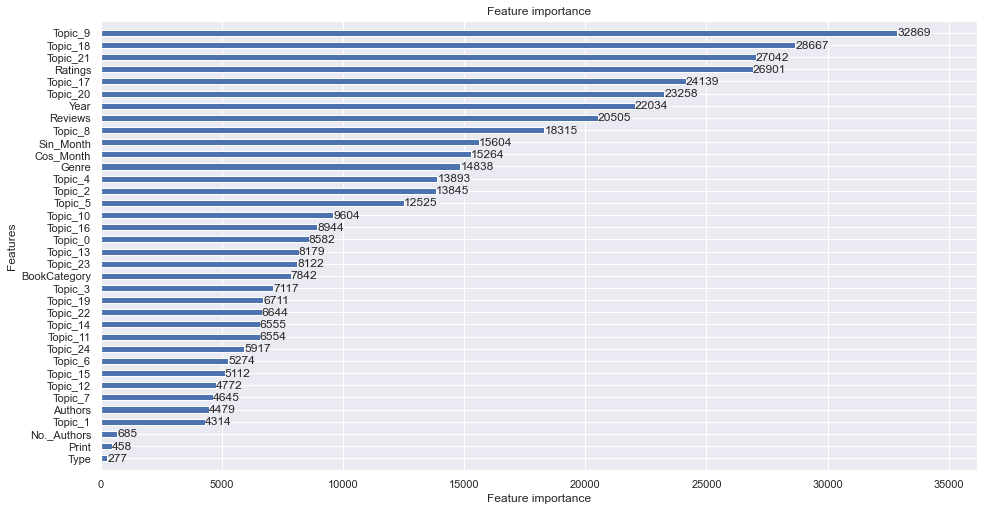

In [122]:
sns.set(font_scale = 1)
lightgbm.plot_importance(model, height=0.5)

In [124]:
# Saving-exporting the results to a .csv file
pd.DataFrame(predictions, columns = ['Price']).to_csv('submission_lgbm_best.csv', index=False)
# 0.75984

More tight grid-search for the speicific model based on the results of the previous one

In [8]:
import lightgbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

lgbm = lightgbm.LGBMRegressor(random_state = 420, n_jobs = -1)

# Using many estimators with low learning rates
lgbm_params = {'learning_rate': [0.02, 0.03, 0.035, 0.04],
                           'num_leaves':[124],
                           'max_depth': [18, 20, 22],
                           'n_estimators': [3500, 3750, 4000],
                           'objective': ['regression_l1']}

lgbm_grid_search = GridSearchCV(estimator = lgbm, 
                                param_grid =  lgbm_params,
                                cv=10,
                                verbose = 10,
                                scoring = make_scorer(nrmsle, greater_is_better=True),
                                n_jobs=-1)

lgbm_grid_search.fit(X_train, y_train)

print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 8/10; 1/36] START learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 8/10; 1/36] END learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.740 total time= 2.4min
[CV 2/10; 2/36] START learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1
[CV 2/10; 2/36] END learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1;, score=0.763 total time= 2.6min
[CV 9/10; 2/36] START learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1
[CV 9/10; 2/36] END learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1;, score=0.743 total time= 2.3min
[CV 7/10; 3/36] START learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1
[CV 7/10; 3/36] END learning_rate=0.02,

[CV 7/10; 1/36] START learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 7/10; 1/36] END learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.752 total time= 2.4min
[CV 4/10; 2/36] START learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1
[CV 4/10; 2/36] END learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1;, score=0.741 total time= 2.6min
[CV 3/10; 3/36] START learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1
[CV 3/10; 3/36] END learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1;, score=0.758 total time= 2.3min
[CV 9/10; 3/36] START learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1
[CV 9/10; 3/36] END learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=reg

[CV 3/10; 1/36] START learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 3/10; 1/36] END learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.758 total time= 2.3min
[CV 9/10; 1/36] START learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 9/10; 1/36] END learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.743 total time= 2.4min
[CV 8/10; 2/36] START learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1
[CV 8/10; 2/36] END learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1;, score=0.740 total time= 2.3min
[CV 6/10; 3/36] START learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1
[CV 6/10; 3/36] END learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=reg

[CV 1/10; 1/36] START learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 1/10; 1/36] END learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.758 total time= 2.4min
[CV 1/10; 2/36] START learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1
[CV 1/10; 2/36] END learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1;, score=0.758 total time= 2.6min
[CV 1/10; 3/36] START learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1
[CV 1/10; 3/36] END learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1;, score=0.758 total time= 2.4min
[CV 1/10; 4/36] START learning_rate=0.02, max_depth=20, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 1/10; 4/36] END learning_rate=0.02, max_depth=20, n_estimators=3500, num_leaves=124, objective=reg

[CV 5/10; 1/36] START learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1
[CV 5/10; 1/36] END learning_rate=0.02, max_depth=18, n_estimators=3500, num_leaves=124, objective=regression_l1;, score=0.742 total time= 2.4min
[CV 6/10; 2/36] START learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1
[CV 6/10; 2/36] END learning_rate=0.02, max_depth=18, n_estimators=3750, num_leaves=124, objective=regression_l1;, score=0.773 total time= 2.6min
[CV 2/10; 3/36] START learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1
[CV 2/10; 3/36] END learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1;, score=0.763 total time= 2.4min
[CV 10/10; 3/36] START learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=regression_l1
[CV 10/10; 3/36] END learning_rate=0.02, max_depth=18, n_estimators=4000, num_leaves=124, objective=r

In [9]:
print("The best estimator across ALL searched params:\n", lgbm_grid_search.best_estimator_)

print("The best score of all model parameters' combination on model: {:.4f}".format(lgbm_grid_search.best_score_))
display(pd.DataFrame(lgbm_grid_search.cv_results_).sort_values(by=['rank_test_score'])[['mean_fit_time', 'mean_score_time', 
                                           'params', 'mean_test_score', 'rank_test_score']])


The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.04, max_depth=22, n_estimators=4000,
              num_leaves=124, objective='regression_l1', random_state=420)
The best score of all model parameters' combination on model: 0.7506


,mean_fit_time,mean_score_time,params,mean_test_score,rank_test_score
35,148.586348,2.362689,"{'learning_rate': 0.04, 'max_depth': 22, 'n_es...",0.750604,1
34,130.508386,3.516438,"{'learning_rate': 0.04, 'max_depth': 22, 'n_es...",0.750597,2
33,122.085660,2.817046,"{'learning_rate': 0.04, 'max_depth': 22, 'n_es...",0.750521,3
28,133.632622,2.992995,"{'learning_rate': 0.04, 'max_depth': 18, 'n_es...",0.750457,4
29,167.959406,3.523344,"{'learning_rate': 0.04, 'max_depth': 18, 'n_es...",0.750440,5
27,121.341240,2.955567,"{'learning_rate': 0.04, 'max_depth': 18, 'n_es...",0.750436,6
26,151.805331,3.558750,"{'learning_rate': 0.035, 'max_depth': 22, 'n_e...",0.750372,7
25,171.561890,4.101946,"{'learning_rate': 0.035, 'max_depth': 22, 'n_e...",0.750368,8
24,144.140115,3.735433,"{'learning_rate': 0.035, 'max_depth': 22, 'n_e...",0.750325,9
1,145.289103,3.167706,"{'learning_rate': 0.02, 'max_depth': 18, 'n_es...",0.750303,10


In [10]:
model = lgbm_grid_search.best_estimator_

model.fit(X_train, y_train)
predictions = model.predict(X_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

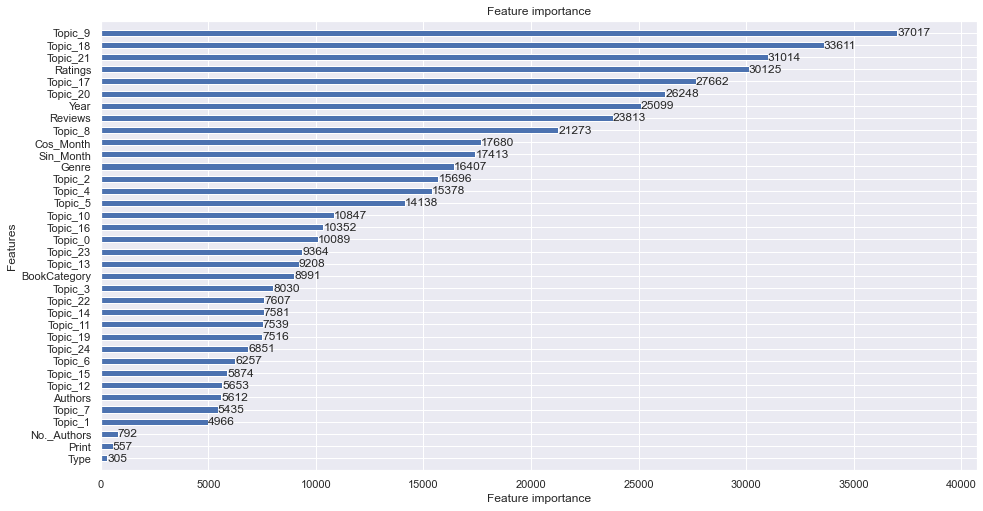

In [13]:
sns.set(font_scale = 1)
lightgbm.plot_importance(model, height=0.5)

In [16]:
# Saving-exporting the results to a .csv file
pd.DataFrame(predictions, columns = ['Price']).to_csv('submission_lgbm_best_final.csv', index=False)
# 0.76038